**Предсказание последовательности**

**Вход:** Последовательность из 10 случайных элементов датасета MNIST
***pic(a_1), pic(a_2), ... , pic(a_10)***

**Выход:** Одно число ***a_11 = a_1 + a_2***


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv2D, TimeDistributed, MaxPooling2D, Flatten, Reshape, Dropout
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

Скачаем MNIST и отнормируем данные:

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Подготовим датасет для обучения:

In [0]:
maxlen = 10 # Длина последовательности
num_classes = 19 # Количество классов
# Оставим часть картинок для валидации
val_size = 5000
sentences = [] # Набор последовательностей для обучения
next_chars = [] # Метки для обучения
for i in range(200000):
    # Получим случайные номера картинок для формирования последовательности
    p = np.random.randint(0, len(x_train)-val_size, maxlen)
    sentences.append(x_train[p])
    next_chars.append(to_categorical(y_train[p[0]]+y_train[p[1]], num_classes))
print('nb sequences:', len(sentences))

nb sequences: 200000


In [0]:
# Проверим размерность полученных данных
np.array(sentences).shape, np.array(next_chars).shape

((200000, 10, 28, 28), (200000, 19))

Посмотрим на элементы полученного датасета:

Последовательность картинок:


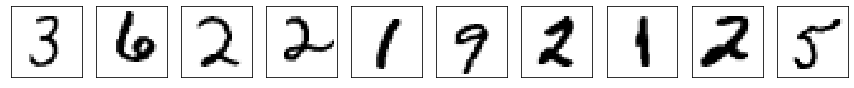

Правильный ответ: 9

Последовательность картинок:


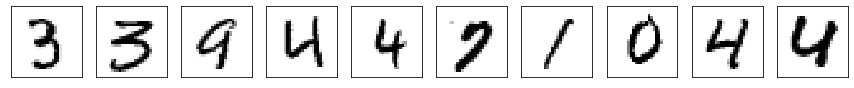

Правильный ответ: 6

Последовательность картинок:


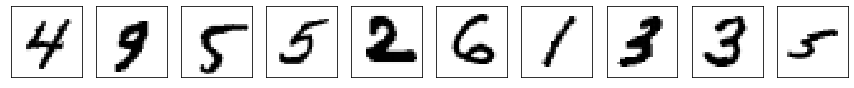

Правильный ответ: 13

Последовательность картинок:


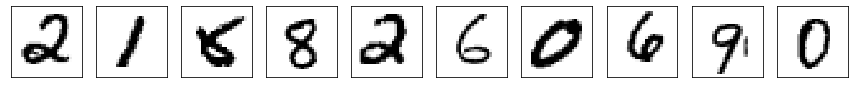

Правильный ответ: 3

Последовательность картинок:


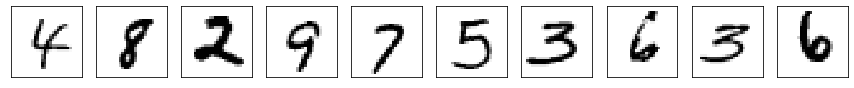

Правильный ответ: 12



In [0]:
for i in range(5):
    print('Последовательность картинок:')
    plt.figure(figsize=(15,5))
    for j in range(maxlen):
        plt.subplot(1,maxlen,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(sentences[i][j], cmap=plt.cm.binary)
    plt.show()
    print('Правильный ответ: {}'.format(np.argmax(next_chars[i])))
    print()

Подготовим датасет для валидации:

In [0]:
val_sentences = [] # Набор последовательностей для валидации
val_next_chars = [] # Метки для валидации
for i in range(20000):
    # Получим случайные номера картинок для формирования последовательности
    # Возьмем из x_train только те картинки, которые не использовались для обучения
    p = np.random.randint(len(x_train)-val_size, len(x_train), maxlen)
    val_sentences.append(x_train[p])
    val_next_chars.append(to_categorical(y_train[p[0]]+y_train[p[1]], num_classes))
print('nb val sequences:', len(val_sentences))

nb val sequences: 20000


Построим модель:

In [0]:
model = Sequential()
# Добавим еще одно измерение для канала изображений
model.add(Reshape((maxlen, 28, 28, 1), input_shape=(maxlen, 28, 28)))
# Пропустим каждую картинку через сверточные слои перед подачей в LSTM
model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2, )))
model.add(TimeDistributed(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2, )))
# Развернем каждую картинку в вектор
model.add(TimeDistributed(Flatten()))
model.add(LSTM(200, input_shape=(maxlen, 6*6*8), dropout=0.25))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(lr=0.001) 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

После каждой эпохи будем выводить предсказание модели для произвольной последовательности из тестового датасета:

In [0]:
def on_epoch_end(epoch, _):
    print()
    p = np.random.randint(0, len(x_test), maxlen)
    x_pred = x_test[p].reshape(-1, maxlen, 28, 28)
    # Чтобы не загромождать вывод, будем печатать только метки (цифры) элементов последовательности
    print('----- Generating with sequence: ', *y_test[p])
    preds = model.predict(x_pred, verbose=0)
    print('----- Prediction: ', np.argmax(preds[0]))
    print('----- Target: ', y_test[p[0]]+y_test[p[1]])
    print()

В процессе обучения будем сохранять модели с лучшими значениями val_loss и val_acc:

In [0]:
best_loss = ModelCheckpoint('/content/drive/My Drive/18/MNIST_best_val_loss.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)
best_acc = ModelCheckpoint('/content/drive/My Drive/18/MNIST_best_val_acc.h5',
                                monitor='val_categorical_accuracy',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

Обучим модель:

In [0]:
%%time
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(np.array(sentences), np.array(next_chars),
          batch_size=250,
          epochs=50,
          callbacks=[print_callback, best_loss, best_acc],
          # Для валидации передадим специально подготовленный набор
          validation_data=(np.array(val_sentences), np.array(val_next_chars))) 

Train on 200000 samples, validate on 20000 samples
Epoch 1/50
200000/200000 [==============================] - 53s 264us/step - loss: 2.4467 - categorical_accuracy: 0.1537 - val_loss: 1.8688 - val_categorical_accuracy: 0.3132

----- Generating with sequence:  0 9 8 7 2 4 4 9 6 8
----- Prediction:  9
----- Target:  9

Epoch 2/50
200000/200000 [==============================] - 51s 254us/step - loss: 1.1088 - categorical_accuracy: 0.6213 - val_loss: 0.2851 - val_categorical_accuracy: 0.9236

----- Generating with sequence:  9 8 4 6 7 3 9 6 1 9
----- Prediction:  17
----- Target:  17

Epoch 3/50
200000/200000 [==============================] - 51s 254us/step - loss: 0.3636 - categorical_accuracy: 0.8980 - val_loss: 0.1702 - val_categorical_accuracy: 0.9519

----- Generating with sequence:  8 0 4 1 6 6 6 2 6 1
----- Prediction:  8
----- Target:  8

Epoch 4/50
200000/200000 [==============================] - 51s 253us/step - loss: 0.2334 - categorical_accuracy: 0.9353 - val_loss: 0.1205 - v

Выведем информацию о модели и сохраним ее:

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 10, 28, 28, 1)     0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 10, 26, 26, 16)    160       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 10, 13, 13, 16)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 12, 12, 8)     520       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 6, 6, 8)       0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 10, 288)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)              

In [0]:
model.save('/content/drive/My Drive/18/MNIST_lstm.h5')

Построим график функции потерь:

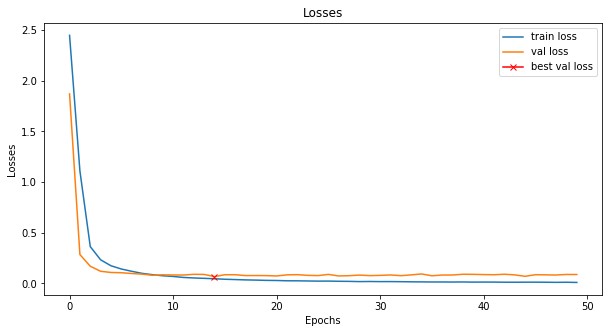

In [0]:
plt.figure(figsize=(10, 5))
plt.title("Losses")
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.plot(np.argmin(history.history['val_loss']), np.min(history.history['val_loss']), marker="x", color="r", label="best val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

Построим график accuracy:

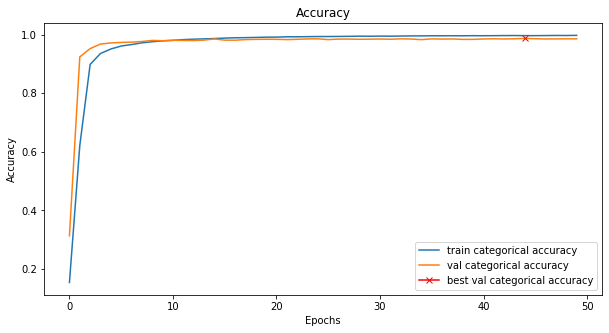

In [0]:
plt.figure(figsize=(10, 5))
plt.title("Accuracy")
plt.plot(history.history['categorical_accuracy'], label="train categorical accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="val categorical accuracy")
plt.plot(np.argmax(history.history['val_categorical_accuracy']), np.max(history.history['val_categorical_accuracy']), marker="x", color="r", label="best val categorical accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Для итоговой проверки составим новые случайные последовательности из тестового датасета:

In [0]:
test_sentences = []
test_next_chars = []
for i in range(25000):
    p = np.random.randint(0, len(x_test), maxlen)
    test_sentences.append(x_test[p])
    test_next_chars.append(to_categorical(y_test[p[0]]+y_test[p[1]], num_classes))
print('nb test sequences:', len(test_sentences))

nb test sequences: 25000


Оценим качество модели:

In [0]:
# model = load_model('/content/drive/My Drive/18/MNIST_lstm.h5')

In [0]:
model.evaluate(np.array(test_sentences), np.array(test_next_chars))

25000/25000 [==============================] - 14s 570us/step


[0.09827232244258281, 0.98288]

MNIST_best_val_loss

In [0]:
model = load_model('/content/drive/My Drive/18/MNIST_best_val_loss.h5')

In [0]:
model.evaluate(np.array(test_sentences), np.array(test_next_chars))

25000/25000 [==============================] - 11s 439us/step


[0.08163124587556347, 0.98096]

MNIST_best_val_acc

In [0]:
model = load_model('/content/drive/My Drive/18/MNIST_best_val_acc.h5')

In [0]:
model.evaluate(np.array(test_sentences), np.array(test_next_chars))

25000/25000 [==============================] - 11s 433us/step


[0.09592031558642862, 0.98324]

Загрузим модель с наилучшим результатом на тесте:

In [0]:
model = load_model('/content/drive/My Drive/18/MNIST_best_val_acc.h5')

Рассмотрим расширенную оценку качества предсказания модели на тестовом датасете:

In [0]:
predictions = model.predict(np.array(test_sentences))

In [0]:
print(classification_report(np.array(test_next_chars).argmax(axis=1), predictions.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9874    0.9958    0.9916       236
           1     0.9915    0.9949    0.9932       584
           2     0.9850    0.9942    0.9896       858
           3     0.9880    0.9834    0.9857      1084
           4     0.9855    0.9847    0.9851      1307
           5     0.9850    0.9830    0.9840      1532
           6     0.9800    0.9873    0.9837      1737
           7     0.9806    0.9890    0.9848      1997
           8     0.9771    0.9906    0.9838      2236
           9     0.9859    0.9867    0.9863      2414
          10     0.9859    0.9790    0.9825      2288
          11     0.9809    0.9829    0.9819      1984
          12     0.9866    0.9777    0.9821      1656
          13     0.9788    0.9726    0.9757      1424
          14     0.9836    0.9836    0.9836      1097
          15     0.9848    0.9811    0.9830      1059
          16     0.9803    0.9664    0.9733       774
          17     0.9847    

Выведем несколько случайных примеров с предсказаниями:

Последовательность картинок:


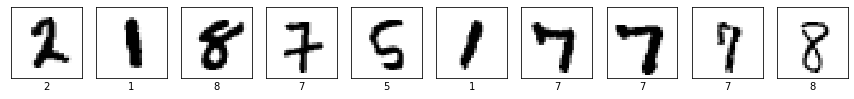

Предсказание модели: 3
Правильный ответ: 3

Последовательность картинок:


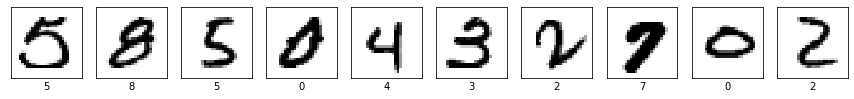

Предсказание модели: 13
Правильный ответ: 13

Последовательность картинок:


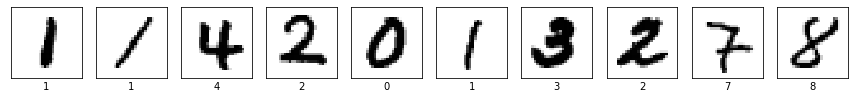

Предсказание модели: 2
Правильный ответ: 2

Последовательность картинок:


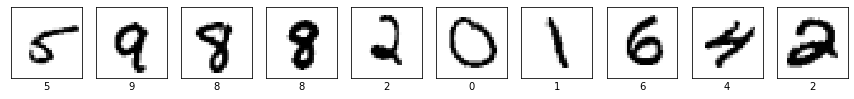

Предсказание модели: 14
Правильный ответ: 14

Последовательность картинок:


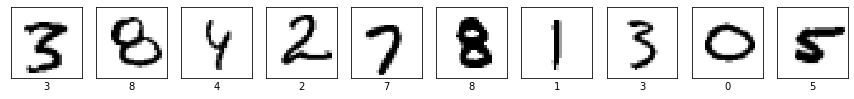

Предсказание модели: 11
Правильный ответ: 11

Последовательность картинок:


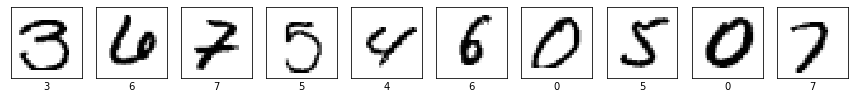

Предсказание модели: 9
Правильный ответ: 9

Последовательность картинок:


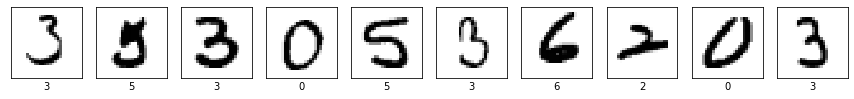

Предсказание модели: 8
Правильный ответ: 8

Последовательность картинок:


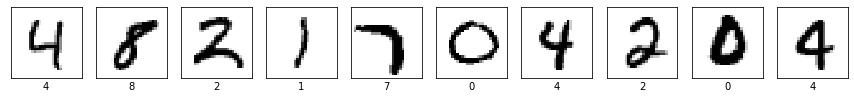

Предсказание модели: 12
Правильный ответ: 12

Последовательность картинок:


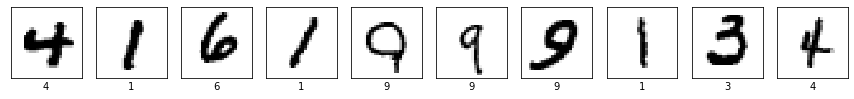

Предсказание модели: 5
Правильный ответ: 5

Последовательность картинок:


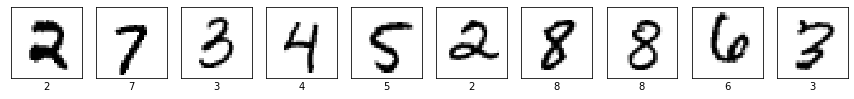

Предсказание модели: 9
Правильный ответ: 9



In [0]:
for i in range(10):
    p = np.random.randint(0, len(x_test), maxlen)
    x_pred = x_test[p].reshape(-1, maxlen, 28, 28)
    preds = model.predict(x_pred, verbose=0)
    print('Последовательность картинок:')
    plt.figure(figsize=(15,5))
    for j in range(maxlen):
        plt.subplot(1,maxlen,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[p][j], cmap=plt.cm.binary)
        plt.xlabel(y_test[p][j])
    plt.show()
    print('Предсказание модели: {}'.format(np.argmax(preds)))
    print('Правильный ответ: {}'.format(y_test[p[0]]+y_test[p[1]]))
    print()